<center><H1>Modelo para problema de regresión estática</H1><center>

<center><img src="https://www.gstatic.com/devrel-devsite/prod/ve2848ad92313fddfcd40baeb58a2f663fe2fd55c371a714a6bb3e329e2b15223/tensorflow/images/lockup.svg"  height="80px" style="padding-bottom:5px;"  /></center>

<center><H2>Julio Waissman Vilanova</H2>

<table align="center">
      <td align="center"><a target="_blank" href="https://www.unison.mx">
            <img src="https://www.unison.mx/wp-content/themes/awaken/images/logo.png"  height="70px" style="padding-bottom:5px;"  /></a></td>  
      <td align="center"><a target="_blank" href="https://www.gob.mx/cenace">
            <img src="https://universidad.cenace.gob.mx/pluginfile.php/244/block_html/content/CENACE-logo-completo.png" width="300" style="padding-bottom:5px;" /></a></td>
      <td align="center"><a target="_blank" href="https://colab.research.google.com/github/juliowaissman/rn-cenace/blob/main/taller_solar-resuelto-otras-variables.ipynb">
            <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Ejecuta en Google Colab</a></td>

</table>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('ggplot')

## Cargando los datos

Vamos a cargar los datos que nos proporcionó la Gerencia Regional Noroeste sobre una planta de generación de energía fotovoltáica y vamos a ver si somos capaces de predecir la Generación de energía utilizando la información de la Radiación, así como la información de la fecha.

In [2]:
url = "https://github.com/juliowaissman/curso-ml-cenace/raw/main/datos/Dataset_GeneracionFV.xlsx"
df = pd.read_excel(url, sheet_name=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5520 entries, 0 to 5519
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              5520 non-null   datetime64[ns]
 1   Generacion_FV_MW   5520 non-null   float64       
 2   Radiacion_FV_W/m2  5520 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 129.5 KB


In [3]:
df.index = df.Fecha
df['Hora'] = df.index.hour
df['Dia'] = df.index.day
df['Mes'] = df.index.month
df.rename(columns={'Radiacion_FV_W/m2': 'Radiacion_FV'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5520 entries, 2021-01-01 01:00:00 to 2021-08-19 00:00:00
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             5520 non-null   datetime64[ns]
 1   Generacion_FV_MW  5520 non-null   float64       
 2   Radiacion_FV      5520 non-null   float64       
 3   Hora              5520 non-null   int64         
 4   Dia               5520 non-null   int64         
 5   Mes               5520 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 301.9 KB


## Hagamos un pequeño análisis exploratorio de datos

<AxesSubplot:xlabel='Generacion_FV_MW', ylabel='Radiacion_FV'>

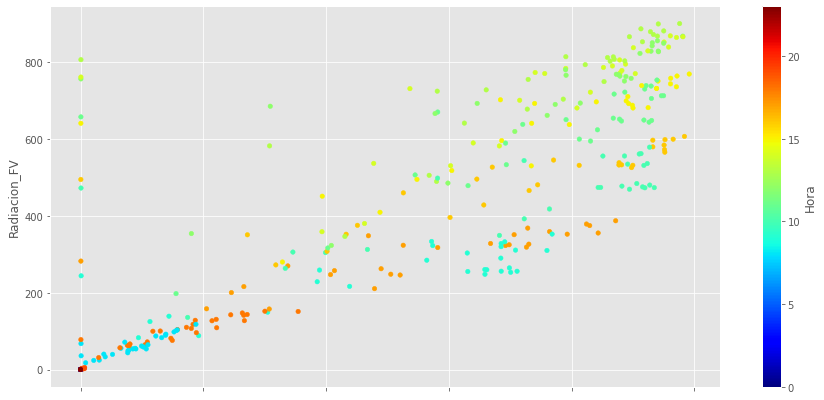

In [4]:
df[df.Mes == 2].plot.scatter(
    x='Generacion_FV_MW',
    y='Radiacion_FV',
    #s='Dia',
    c='Hora',
    colormap='jet',
    figsize=(15,7)
)

Al parecer hay varios valores aberrantes que deberíamos limpiar para hacer una predicción, por el momento vamos a dejarlos y regresaremos con la limpieza en un segundo término

In [51]:
df.query('Radiacion_FV > 20 and Generacion_FV_MW < .5').Dia.value_counts()

1    34
0    25
2    21
3    20
4    18
6    15
5     3
Name: Dia, dtype: int64

## Predicción de la generación usando redes neuronales

Para este problema vamos a ir desarrollando el problema paso a paso.

Para esto vamos a hacer algunas hipótesis:

- El problema es estático: la generación de energía va a depender sólo de la radiación en el mismo momento, la hora del día, el día del mes y el mes del año.

- Los datos como hora, día y mes los vamos a codificar directamente, y luego veremos como funciona con one-hot encoding

- Vamos aprobar primero si sólo con la radiación es posible generalizar algo decente.


### Paso 1: Seleccionar los datos y separar en conjunto de datos de entrenamiento y conjunto de datos de prueba

In [59]:
#x = df[['Radiacion_FV', 'Hora', 'Mes']].to_numpy()

dfdummy = df\
   .join(pd.get_dummies(df.Hora, prefix='H', drop_first=True))\
   .join(pd.get_dummies(df.Mes, prefix='M', drop_first=True))

x = dfdummy[
    ['Radiacion_FV'] + 
    [f'H_{i}' for i in range(1,24)] + 
    [f'M_{j}' for j in range(2, 9)]
].to_numpy()

y = df.Generacion_FV_MW.to_numpy()

#TODO: Al terminar de hacer el modelo 
#    con solo una entrada y una salida, probar 
#    agregar otras variables y documentar

print(f"La forma de x: {x.shape} y la de y = {y.shape}")

#TODO: Separa en un conjunto de prueba y otro de test
#      (decide cuanto usar para cada uno)

indices = list(range(x.shape[0]))
np.random.shuffle(indices)

x_train = x[indices[520:],:]
y_train = y[indices[520:]]
x_test = x[indices[:520],:]
y_test = y[indices[:520]]

La forma de x: (5520, 31) y la de y = (5520,)


### Paso 2: definir una red neuronal 

Recuerda que solo tenemos 5000 datos de entrenamiento (de ser posible, el número de parámetros menor a 10 veces el número de datos de entrenamiento)

In [95]:
def modelo_sin_compil(nombre="Solar_1"):
    modelo = keras.models.Sequential(name=nombre)

    #TODO: ajusta un modelo
    modelo.add(layers.Dense(40, activation="sigmoid", input_shape=(x.shape[1],), name="capa_1"))
    modelo.add(layers.Dense(1, activation="linear", name="capa_3"))
    return modelo

modelo = modelo_sin_compil()

modelo.summary()

Model: "Solar_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 40)                1280      
_________________________________________________________________
capa_3 (Dense)               (None, 1)                 41        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


### Paso 3 Compila el modelo

Selecciona los parámetros que creas más convenientes

In [96]:
def modelo_compilado():
    model = modelo_sin_compil()
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanAbsoluteError(),
        metrics=[
            keras.metrics.MeanAbsolutePercentageError()
        ],
    )
    return model

modelo = modelo_compilado()

### Paso 4 Entrena el modelo

Vamos a repetir este paso mientras parezca que no hay sobreaprendizaje (vamos a hacer el early stoping a mano en este caso)

In [104]:
num_epochs = 30
print(f"Entrenamiento del modelo en {num_epochs} epochs")

history = modelo.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=num_epochs,
    validation_split=0.2 # Porcentaje de datos para usar como validación
)

Entrenamiento del modelo en 30 epochs
Epoch 1/30
63/63 [==============================] - 0s 2ms/step - loss: 6.1931 - mean_absolute_percentage_error: 22403598.0000 - val_loss: 6.3825 - val_mean_absolute_percentage_error: 19436644.0000
Epoch 2/30
63/63 [==============================] - 0s 1ms/step - loss: 5.9923 - mean_absolute_percentage_error: 20682430.0000 - val_loss: 6.2507 - val_mean_absolute_percentage_error: 21353936.0000
Epoch 3/30
63/63 [==============================] - 0s 1ms/step - loss: 5.9148 - mean_absolute_percentage_error: 20619550.0000 - val_loss: 6.1139 - val_mean_absolute_percentage_error: 19401966.0000
Epoch 4/30
63/63 [==============================] - 0s 1ms/step - loss: 5.9020 - mean_absolute_percentage_error: 20384676.0000 - val_loss: 6.3019 - val_mean_absolute_percentage_error: 20155682.0000
Epoch 5/30
63/63 [==============================] - 0s 1ms/step - loss: 5.9592 - mean_absolute_percentage_error: 21143102.0000 - val_loss: 6.1384 - val_mean_absolute_perc

In [105]:
pd.DataFrame(history.history)

,loss,mean_absolute_percentage_error,val_loss,val_mean_absolute_percentage_error
0,6.193076,22403598.0,6.382520,19436644.0
1,5.992306,20682430.0,6.250737,21353936.0
2,5.914824,20619550.0,6.113902,19401966.0
3,5.901975,20384676.0,6.301902,20155682.0
4,5.959181,21143102.0,6.138409,20509850.0
5,5.812593,22161684.0,6.055500,23679664.0
6,5.751818,22177118.0,5.931494,27095580.0
7,5.617883,22841632.0,6.039124,19956876.0
8,5.550753,22008770.0,5.762556,23378852.0
9,5.512362,22203882.0,5.784388,18722862.0


### Paso 5 Evalúa con los datos de prueba

Este paso se ejecuta sólamente si el valor de pérdida y de las métricas se consideran aceptables. Si no es necesario buscar nuevos modelos.

In [106]:
print("Evaluando en los datos de prueba")

results = modelo.evaluate(x_test, y_test, batch_size=128)

print("\n\nPérdida en test, MAE en test:", results)

Evaluando en los datos de prueba
5/5 [==============================] - 0s 2ms/step - loss: 5.9720 - mean_absolute_percentage_error: 23359968.0000


Pérdida en test, MAE en test: [5.971972942352295, 23359968.0]


### Paso 6 Simula para todos los datos

Vamos a predecir para todos los datos y ver como se comporta el modelo respecto a los datos que tenemos:

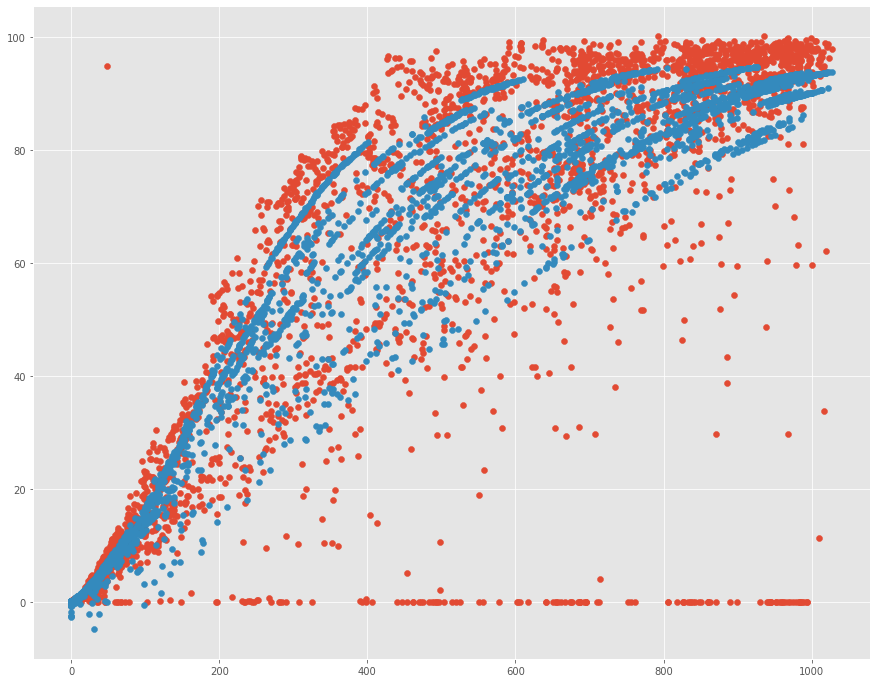

In [107]:
y_est = modelo.predict(x)

plt.figure(figsize=(15, 12))
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], y_est)

### Paso 7 Revisa y critica el modelo

Si el modelo te gustó y crees que vale la pena mantenerlo, entonces guardalo en disco, y agrega un archivo texto con la explicacion del modelo.

Realiza una funcion ```preprocesamiento_modelo1``` tal que reciba el nombre del archivo y devuelva los datos en la forma que se requiere para poder estimar con tu modelo


In [94]:
def preprocesamiento_modelo1(file):
    """Regresa x, y usados en el modelo1"""
    df = pd.read_excel(url, sheet_name=1)
    df.rename(columns={'Radiacion_FV_W/m2': 'Radiacion_FV'}, inplace=True)
    return df.Radiacion_FV.to_numpy(), df.Generacion_FV_MW.to_numpy()

modelo.save("modelo_1.h5")

nota = """Modelo 1
Entrada: 'Radiacion_FV_W/m2'
Salida: 'Generacion_FV_MW'
"""  

with open('modelo_1.txt', 'w+') as fh:
    fh.write(nota)
    
    

### Paso 8 Prueba un modelo diferente

¿Habrá un mejor modelo? ¿Uno similar con menos parámetros? ¿La selección que se realizó es la correcta en cuanto a método de optimización? ¿Sería bueno agregar regularización?

¿Que pasaria si se toma en cuenta la hora y el día? ¿Y si se consideran valores pasados?